In [2]:
import tensorflow as tf
import numpy as np
import importlib
import pandas as pd
import time
import sys, os
import matplotlib.pylab as plt
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), "..","..","onn"))
import dnn 


#%load_ext tensorboard

### 0 Load training data, test data and detector mask

In [3]:
def getDetector(N_mesh = 28):
    detector = pd.read_csv(os.path.join("..","..","detector_masks",'detector_template_28.txt'), 
                       index_col=0, dtype=np.float32,low_memory=False)
    detector_template = detector.iloc[1:, ].values.astype('float32')
    
    #Original size of detector
    orig_size = int(np.sqrt(np.shape(detector_template)[-1]))
    #resize detector to desitred meshing
    detector_template = tf.reshape(detector_template, (-1,orig_size, orig_size, 1))
    detector_template = tf.keras.layers.Resizing(N_mesh, N_mesh, interpolation="nearest")(detector_template)
    detector = tf.reshape(detector, (-1,orig_size, orig_size, 1))
    detector = tf.keras.layers.Resizing(N_mesh, N_mesh, interpolation="nearest")(detector)
    
    return tf.reshape(detector,(-1,N_mesh*N_mesh)),tf.reshape(detector_template,(-1,N_mesh*N_mesh))
a,b = getDetector()
print(tf.shape(b))
print(tf.shape(a))

tf.Tensor([ 10 784], shape=(2,), dtype=int32)
tf.Tensor([ 11 784], shape=(2,), dtype=int32)


In [4]:
# Trainings and Validation Data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float64") / 255.0 
x_test  = x_test.astype("float64") / 255.0  
input_shape = x_test[0].shape

#Detector
detector, detector_template = getDetector()


### 1 Build Model and Train

#### 1.0 Build model

In [8]:
print("\nCheck a specific class within module")
print(dnn.Meta.__doc__)


Check a specific class within module

    A neural network layer that represents the metasurface, it manipulates the amplitude and phase of the incident field.
    By default only the phase is trainable. In Neural Network terminology it represents an a linear activation.
    The factor m in f(x)=m*x is determined by the phase and amplitude modulation by the metasurface at each pixel.

    Attributes:
        amplitude (float32):    variable containing the amplitude manipulation due to the metasurface
        theta (float32):        trainable variable containing the phase shift due to the metasurface

    Arguments:
        N_meta (int):    number of pixels of our square input metasurface (in one direction)
        N_mesh (int):    number of meshing points, choose such that there is at least one meshing point for half a wavelength
                        it is desirable if N_out is a multiple of N_meta
        **kwargs:       grants access to variables of the keras base layer class (se

In [5]:
importlib.reload(dnn)
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model, Sequential

#Here I define a little onn
def get_model(input_shape, N_meta, N_mesh, D_scale1, D_scale2, D_scale3, zScale1, zScale2, lam):

    #Get Detector
    _, detector = getDetector(N_mesh)

    # Define the Model Layers
    input_layer = Input(shape = input_shape)
    x = Flatten()(tf.cast(input_layer, tf.complex64))
    x = dnn.Meta(N_mesh = input_shape[0], N_meta = N_meta)(x)
    x = dnn.FreeSpacePropagation(N_mesh_in  = input_shape[0], N_mesh_out = N_mesh, 
                                 D_scale_in = D_scale1, D_scale_out = D_scale2, 
                                 lam  = lam, zScale   = zScale1)(x)
    x = dnn.Meta(N_mesh = N_mesh, N_meta = N_meta)(x)
    x = dnn.FreeSpacePropagation(N_mesh_in  = N_mesh, N_mesh_out = N_mesh, 
                                 D_scale_in = D_scale1, D_scale_out = D_scale3,  
                                 lam  = lam, zScale   = zScale2)(x)
    output_layer = dnn.ToDetector(detector)(x)
    
    # Build Model
    model = Model(inputs=input_layer, outputs=output_layer, name="model")


    # Optimize Parameters
    learning_rate = 0.001
    optimizer     = tf.keras.optimizers.Adam(learning_rate)
    metrics       = [tf.keras.metrics.SparseCategoricalAccuracy()]
    loss          = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    # Compile Model
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics)

    return model

In [10]:
#TEST MODEL 

import time

#Physical Parameters
lam        = 0.785                   #wavelength in nm
N_input    = np.shape(x_train)[-1] #number of input pixels, in one dimension
N_meta     = 28                    #number of output pixels, in one dimension
D_scale1   = 14.93
D_scale2   = 14.93
D_scale3   = 14.93
N_mesh     = int(np.ceil(D_scale1*2))
zScale1    = 32                    #interlayer distance as a factor of lamda
zScale2    = zScale1               #interlayer distance as a factor of lamda

#Display Model
model      = get_model(input_shape,  N_meta = N_meta, N_mesh = N_mesh, 
                D_scale1 = D_scale1, D_scale2 = D_scale2, D_scale3 = D_scale3, 
                       zScale1 = zScale1, zScale2 = zScale2, lam = lam)
Model.summary(model, expand_nested=True, show_trainable=True)

# Trainings Parameter
batch_size = 8
epochs     = 3

# Train Model
t = time.time()
history        = model.fit(x_train, y_train,
    batch_size = batch_size,
    shuffle    = True,
    verbose    = 1,
    epochs     = epochs,
    callbacks  = tf.keras.callbacks.EarlyStopping(patience=2),
    validation_data = (x_test, y_test))
print("The training required:\t", time.time()-t, "s")

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_1 (InputLayer)        [(None, 28, 28)]          0         Y          
                                                                            
 tf.cast (TFOpLambda)        (None, 28, 28)            0         Y          
                                                                            
 flatten (Flatten)           (None, 784)               0         Y          
                                                                            
 meta (Meta)                 (None, 784)               1568      Y          
                                                                            
 free_space_propagation (Fre  (None, 900)              0         Y          
 eSpacePropagation)                                                         
                                                             

In [11]:
history        = model.fit(x_train, y_train,
    batch_size = 200,
    shuffle    = True,
    verbose    = 1,
    epochs     = 2,
    callbacks  = tf.keras.callbacks.EarlyStopping(patience=2),
    validation_data = (x_test, y_test))


Epoch 1/2
300/300 [==============================] - 25s 70ms/step - loss: 1.6758 - sparse_categorical_accuracy: 0.8600 - val_loss: 1.6724 - val_sparse_categorical_accuracy: 0.8642
Epoch 2/2
300/300 [==============================] - 18s 59ms/step - loss: 1.6749 - sparse_categorical_accuracy: 0.8620 - val_loss: 1.6717 - val_sparse_categorical_accuracy: 0.8659


(2, 28, 28)


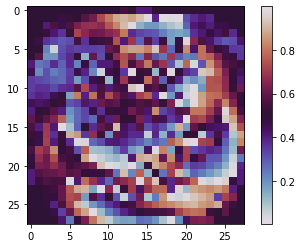

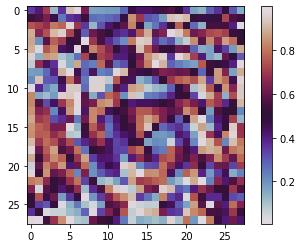

In [9]:
#Get Weights
w = np.zeros((4,28*28))
for i,weights in enumerate(model.get_weights()):
    w[i] = weights

#Plot Weights
res = np.zeros((2,28,28))
y = w[0]
y[y<0] +=1
y[y>1] -=1
plt.figure()
plt.imshow(np.reshape(y, (28,28)), cmap = "twilight")
plt.colorbar()
res[0] = np.reshape(y, (28,28))

y = w[2]
y[y<0] +=1
y[y>1] -=1
plt.figure()
plt.imshow(np.reshape(y, (28,28)), cmap = "twilight")
plt.colorbar()
res[1] = np.reshape(y, (28,28))

#save
file = "Optim_28x28.npy"
np.save(file, res)
print(np.shape(np.load(file)))

#### 1.2 Parameter Scan (28x28 Neurons) 

In [ ]:
# Parameters and constraints

N_input    = np.shape(x_train)[-1] #number of input pixels, in one dimension
N_meta     = 28                    #number of output pixels, in one dimension
max_meta_ratio = 0.8
lam           = 0.785 # wavelength in µm
pixelsize_min = 0.340 # minimal neuron size given by the objective in µm
pixelsize_max = 0.826 # maximal neuron size given by the objective in µm
DScales       = np.linspace(pixelsize_min/lam*N_meta, pixelsize_max/lam*N_meta, 9)
d_min         = 30  # minimal lateral size of the metasurface holder in µm
d_max         = 60  # minimal lateral size of the metasurface holder in µm
zScales       = np.linspace(d_min/lam, d_max/lam, 9)
print("\nDScales:", DScales)
print("\nzScales:", zScales)

# Trainings Parameter
batch_size = 150
epochs     = 2

#Parameter Scan
result = np.zeros((len(zScales), len(DScales)))
for i,zScale in enumerate(zScales):
    zScale1 = zScale
    zScale2 = zScale
    for j,DScale in enumerate(DScales):
        N_mesh = int(np.ceil(DScale*2))
        N_detector = 37
        #If metasurface is bigegr than the size of 3d printed area
        if result[i,j] == 0:
            if zScale < DScale:
                continue
            else:
                model      = get_model(input_shape, N_meta = N_meta, 
                                       N_mesh = N_mesh, D_scale1 = DScale, D_scale2= DScale, D_scale3= DScale, 
                                       zScale1 = zScale, zScale2 = zScale, lam = lam)
                history        = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    shuffle    = True,
                    verbose    = False,
                    epochs     = epochs,
                    callbacks  = tf.keras.callbacks.EarlyStopping(patience=2),
                    validation_data = (x_test, y_test))
                result[i,j] = history.history['sparse_categorical_accuracy'][-1]

    print(i,j, result[i,j])


DScales: [12.12738854 14.29426752 16.4611465  18.62802548 20.79490446 22.96178344
 25.12866242 27.2955414  29.46242038]

zScales: [38.21656051 42.99363057 47.77070064 52.5477707  57.32484076 62.10191083
 66.87898089 71.65605096 76.43312102]


In [ ]:
N_input    = np.shape(x_train)[-1] #number of input pixels, in one dimension
N_meta     = 28                    #number of output pixels, in one dimension

max_meta_ratio = 0.8
lam           = 0.785 # wavelength in µm
pixelsize_min = 0.340 # minimal neuron size given by the objective in µm
pixelsize_max = 0.826 # maximal neuron size given by the objective in µm
DScale        = np.linspace(pixelsize_min/lam*N_meta, pixelsize_max/lam*N_meta, 11)
d_min         = 30  # minimal lateral size of the metasurface holder in µm
d_max         = 60  # minimal lateral size of the metasurface holder in µm
zScales       = np.linspace(d_min/lam, d_max/lam, 11)

for j,DScale in enumerate(DScales):
        print(N_mesh)

In [ ]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6,4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

#Find maximal Values
maxAcc = np.max(result)
i,j    = np.unravel_index(np.argmax(result), result.shape)
zBest  = zScales[i]*lam
dBest  = lam/DScales[j]

#Plot Result
x = DScales*lam
y = zScales*lam
#y = f_metas
extent = [ np.max(x), np.min(x), np.min(y), np.max(y)]

plt.figure()
im = plt.imshow(result, extent = extent, aspect = "auto", origin = "lower", vmin=0.75, vmax=maxAcc)
plt.ylabel("z [µm]")
plt.xlabel("lateral size of metasurface [µm]")
plt.colorbar(im)
plt.show()

print(maxAcc)

#### Best results

In [207]:
#Train properly for best parameter
batch_size = 8
epochs     = 10

# Train Model
N_mesh     = int(np.ceil(dBest*2))
model      = get_model(input_shape, input_shape, N_meta = N_meta, 
                        N_mesh = N_mesh, D_scale1 = dBest, D_scale2 = dBest, D_scale3= DScale, 
                        zScale1 = zBest, zScale2 = zBest, lam = lam)
t = time.time()
history        = model.fit(x_train, y_train,
    batch_size = batch_size,
    shuffle    = True,
    verbose    = 1,
    epochs     = epochs,
    callbacks  = tf.keras.callbacks.EarlyStopping(patience=2),
    validation_data = (x_test, y_test))
print("The training required:\t", time.time()-t, "s")


Epoch 1/10
7500/7500 [==============================] - 52s 6ms/step - loss: 1.7679 - sparse_categorical_accuracy: 0.8095 - val_loss: 1.7126 - val_sparse_categorical_accuracy: 0.8739
Epoch 2/10
7500/7500 [==============================] - 45s 6ms/step - loss: 1.7116 - sparse_categorical_accuracy: 0.8704 - val_loss: 1.7013 - val_sparse_categorical_accuracy: 0.8807
Epoch 3/10
7500/7500 [==============================] - 48s 6ms/step - loss: 1.7046 - sparse_categorical_accuracy: 0.8739 - val_loss: 1.6971 - val_sparse_categorical_accuracy: 0.8841
Epoch 4/10
7500/7500 [==============================] - 44s 6ms/step - loss: 1.7014 - sparse_categorical_accuracy: 0.8750 - val_loss: 1.6941 - val_sparse_categorical_accuracy: 0.8847
Epoch 5/10
7500/7500 [==============================] - 44s 6ms/step - loss: 1.6987 - sparse_categorical_accuracy: 0.8753 - val_loss: 1.6926 - val_sparse_categorical_accuracy: 0.8840
Epoch 6/10
7500/7500 [==============================] - 44s 6ms/step - loss: 1.6975 -

Best Results: 32.99999999999999 0.826


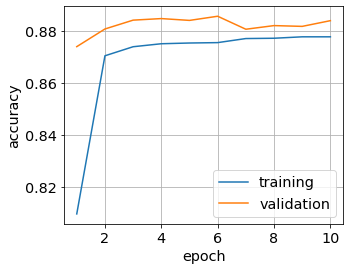

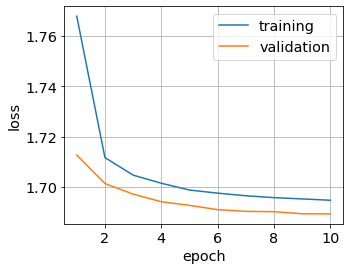

0.8776833415031433
0.883899986743927


In [209]:
keys = history.history.keys()
print("Best Results:", zBest,pBest)

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (5,4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

pylab.rcParams.update(params)

#Plot Accuracy
plt.figure()
plt.plot(range(1,11),history.history[ 'sparse_categorical_accuracy'], label = "training")
plt.plot(range(1,11),history.history['val_sparse_categorical_accuracy'], label = "validation")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid()
plt.legend()
plt.show()

#Plot Loss
plt.figure()
plt.plot(range(1,11),history.history['loss'], label = "training")
plt.plot(range(1,11),history.history['val_loss'], label = "validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.show()

print(history.history[ 'sparse_categorical_accuracy'][-1])
print(history.history[ 'val_sparse_categorical_accuracy'][-1])

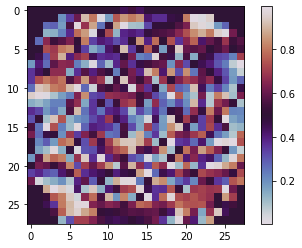

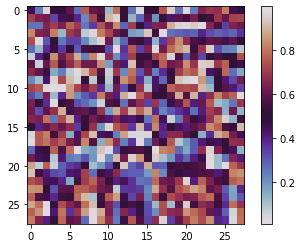

In [15]:
#Plot and save Phase of Model

#Get Weights
w = np.zeros((4,28*28))
for i,weights in enumerate(model.get_weights()):
    w[i] = weights

#Plot Weights
res = np.zeros((2,28,28))
y = w[0]
y[y<0] +=1
y[y>1] -=1
plt.figure()
plt.imshow(np.reshape(y, (28,28)), cmap = "twilight")
plt.colorbar()
res[0] = np.reshape(y, (28,28))

y = w[2]
y[y<0] +=1
y[y>1] -=1
plt.figure()
plt.imshow(np.reshape(y, (28,28)), cmap = "twilight")
plt.colorbar()
res[1] = np.reshape(y, (28,28))

#save
np.save("Optim_GA_28x28", res)
#print(np.shape(np.load("test_phasemask.npy")))


In [17]:
#Plot Intensity
# Plot Propagation through system
N_mesh = N_Mesh
#Define the outputs I am interested in
model_part_1 = Model(
  inputs=model.input,
  outputs=model.get_layer(index = 4).output)
model_part_2 = Model(
  inputs=model.input,
  outputs=model.get_layer(index = 6).output)

#Get intermediate output of test images
testImages = np.array([x_train[1],x_train[9],x_train[5]])
ax0 = np.reshape(testImages, (3*28,28))
ax1 = np.abs(np.reshape(model_part_1(testImages), (3*N_mesh,N_mesh)))**2
ax2 = np.abs(np.reshape(model_part_2(testImages), (3,N_mesh,N_mesh)))**2
ax3 = np.array([np.reshape(mask, (N_mesh,N_mesh))*ax for ax in ax2])
ax3 = np.reshape(ax3, (3*N_mesh,N_mesh))
ax2 =  np.reshape(ax2, (3*N_mesh,N_mesh))

#detector Mask
mask = detector.iloc[0, ].values.astype('float32')
mask = np.reshape(mask, input_shape)

plt.figure()
fig, axs = plt.subplots(1,4, figsize = (10,10))
axs[0].imshow(ax0)
axs[1].imshow(ax1)
axs[2].imshow(ax2)
axs[3].imshow(ax3)
fig.tight_layout()
plt.show()
plt.close()


NameError: name 'N_mesh' is not defined

### Optimization via Bayesian 

If this prooves to be reliable, I might use two different scales, 
for the distances and also different meta pixelSize.
Increasing N means more neurons but also less available distances.
In short I can optimize for: 
- dMeta1
- dMeta2
- z1
- z2

### Bayesian optimization

In [8]:
from bayes_opt import BayesianOptimization
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model, Sequential

def black_box_function(d1, d2, d3, z1, z2, N_meta = 28, lam = 0.785):
    
    # Physical Parameters in wavelength independend ones
    #N_meta   = int(np.floor(N_meta)) #force integer Values
    zScale1  = z1/lam
    zScale2  = z2/lam
    dScale1  = d1/lam
    dScale2  = d2/lam
    dScale3  = d3/lam
    
    
    # Trainings Parameter
    batch_size = 150
    epochs     = 2
    
    # Model Training
    d = np.max([dScale1, dScale2,dScale3])
    N_mesh = 35#int(np.ceil(d*2))
    if d1<z1:
        model      = get_model(input_shape, N_meta = N_meta, N_mesh = N_mesh, 
                               D_scale1 = dScale1, D_scale2 = dScale2, D_scale3 = dScale3, 
                               zScale1 = z1, zScale2 = z2, lam = lam)
        history        = model.fit(x_train, y_train,
            batch_size = batch_size,
            shuffle    = True,
            verbose    = False,
            epochs     = epochs,
            callbacks  = tf.keras.callbacks.EarlyStopping(patience=2),
            validation_data = (x_test, y_test))
        result = history.history['sparse_categorical_accuracy'][-1]
    else:
        result = 0
        
    return result


#black_box_function(d1, d2, d3, z1, z2, N_meta = 28, lam = 0.785)        

In [ ]:
pixelsize_max = 0.826 # maximal neuron size given by the objective in µm
lam = 0.785
# Bounded region of parameter space
N_meta = 28
pbounds = {'d1': (0.60*N_meta, pixelsize_max*N_meta), 
           'd2': (0.60*N_meta, pixelsize_max*N_meta),
           'd3': (0.60*N_meta, pixelsize_max*N_meta),
           'z1': (30, 40),
           'z2': (30, 40)}

#Optimize the objective
optimizer = BayesianOptimization(f = black_box_function, pbounds = pbounds, random_state = 1)
optimizer.maximize(init_points = 8, n_iter = 15)

#Display Results
print(optimizer.max)

|   iter    |  target   |    d1     |    d2     |    d3     |    z1     |    z2     |
-------------------------------------------------------------------------------------
| 1         | 0.8066    | 19.44     | 21.36     | 16.8      | 33.02     | 31.47     |
| 2         | 0.8025    | 17.38     | 17.98     | 18.99     | 33.97     | 35.39     |
| 3         | 0.8049    | 19.45     | 21.14     | 18.09     | 38.78     | 30.27     |
| 4         | 0.8039    | 21.04     | 19.44     | 20.34     | 31.4      | 31.98     |
| 5         | 0.8136    | 21.87     | 22.93     | 18.78     | 36.92     | 38.76     |
| 6         | 0.8153    | 22.46     | 17.34     | 17.05     | 31.7      | 38.78     |
| 7         | 0.8133    | 17.42     | 19.46     | 22.86     | 35.33     | 36.92     |


In [12]:
#Train properly for best parameter
batch_size = 8
epochs     = 10
N_mesh     = 40
dScale1, dScale2, dScale3, z1, z2 = (18.31/lam, 21.76/lam, 22.27/lam, 30.55/lam, 37.15/lam)
# Train Model
model      = get_model(input_shape, N_meta = N_meta, N_mesh = N_mesh, 
                        D_scale1 = dScale1, D_scale2 = dScale2, D_scale3 = dScale3, 
                        zScale1 = z1, zScale2 = z2, lam = lam)
t = time.time()
history        = model.fit(x_train, y_train,
    batch_size = batch_size,
    shuffle    = True,
    verbose    = 1,
    epochs     = epochs,
    callbacks  = tf.keras.callbacks.EarlyStopping(patience=2),
    validation_data = (x_test, y_test))
print("The training required:\t", time.time()-t, "s")


Epoch 1/10
7500/7500 [==============================] - 139s 16ms/step - loss: 1.7421 - sparse_categorical_accuracy: 0.7958 - val_loss: 1.6761 - val_sparse_categorical_accuracy: 0.8675
Epoch 2/10
7500/7500 [==============================] - 115s 15ms/step - loss: 1.6755 - sparse_categorical_accuracy: 0.8663 - val_loss: 1.6682 - val_sparse_categorical_accuracy: 0.8754
Epoch 3/10
7500/7500 [==============================] - 116s 15ms/step - loss: 1.6691 - sparse_categorical_accuracy: 0.8712 - val_loss: 1.6617 - val_sparse_categorical_accuracy: 0.8794
Epoch 4/10
7500/7500 [==============================] - 116s 15ms/step - loss: 1.6658 - sparse_categorical_accuracy: 0.8731 - val_loss: 1.6624 - val_sparse_categorical_accuracy: 0.8740
Epoch 5/10
7500/7500 [==============================] - 111s 15ms/step - loss: 1.6639 - sparse_categorical_accuracy: 0.8738 - val_loss: 1.6594 - val_sparse_categorical_accuracy: 0.8793
Epoch 6/10
7500/7500 [==============================] - 112s 15ms/step - lo

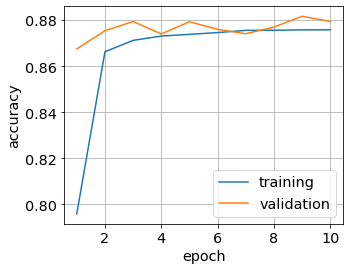

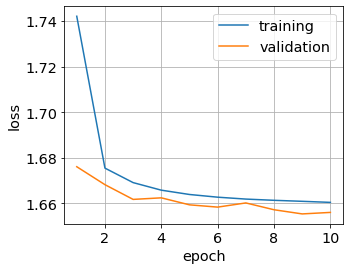

0.8758000135421753
0.8794000148773193


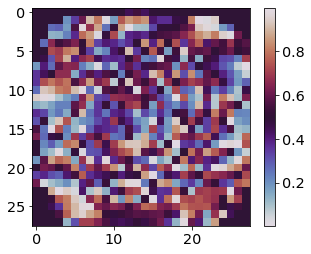

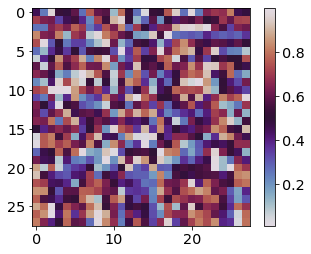

In [22]:
'''keys = history.history.keys()
print("Best Results:", zBest,pBest)'''
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (5,4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

pylab.rcParams.update(params)

#Plot Accuracy
plt.figure()
plt.plot(range(1,11),history.history[ 'sparse_categorical_accuracy'], label = "training")
plt.plot(range(1,11),history.history['val_sparse_categorical_accuracy'], label = "validation")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid()
plt.legend()
plt.show()

#Plot Loss
plt.figure()
plt.plot(range(1,11),history.history['loss'], label = "training")
plt.plot(range(1,11),history.history['val_loss'], label = "validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.show()

print(history.history[ 'sparse_categorical_accuracy'][-1])
print(history.history[ 'val_sparse_categorical_accuracy'][-1])

#Plot and save Phase of Model
#Get Weights
w = []
for i,weights in enumerate(model.get_weights()):
    w.append(weights)

#Plot Weights
res = []
y = w[0]
y[y<0] +=1
y[y>1] -=1
plt.figure()
plt.imshow(np.reshape(y, (28,28)), cmap = "twilight")
plt.colorbar()
res.append(np.reshape(y, (28,28)))

y = w[2]
y[y<0] +=1
y[y>1] -=1
plt.figure()
plt.imshow(np.reshape(y, (28,28)), cmap = "twilight")
plt.colorbar()
res.append(np.reshape(y, (28,28)))

#save
np.save("Optim_28x28", res)

In [23]:
Model.summary(model, expand_nested=True, show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_25 (InputLayer)       [(None, 28, 28)]          0         Y          
                                                                            
 tf.cast_24 (TFOpLambda)     (None, 28, 28)            0         Y          
                                                                            
 flatten_72 (Flatten)        (None, 784)               0         Y          
                                                                            
 meta_48 (Meta)              (None, 784)               1568      Y          
                                                                            
 free_space_propagation_48 (  (None, 1600)             0         Y          
 FreeSpacePropagation)                                                      
                                                             

<Figure size 360x288 with 0 Axes>

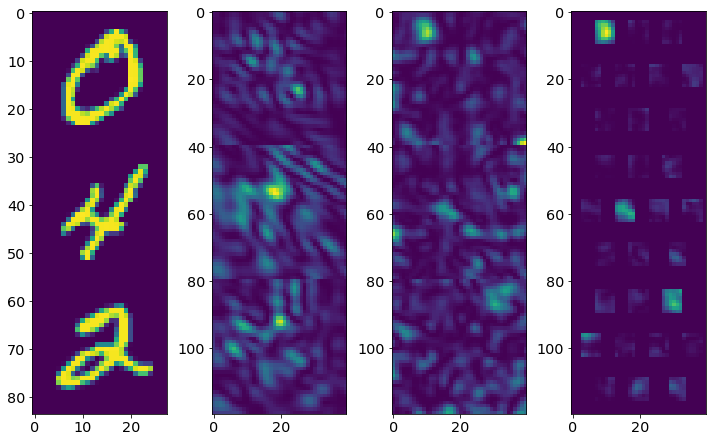

In [37]:
# Plot Propagation through system
N_mesh = 40

#Define the outputs I am interested in
model_part_1 = Model(
  inputs=model.input,
  outputs=model.get_layer(index = 4).output)
model_part_2 = Model(
  inputs=model.input,
  outputs=model.get_layer(index = 6).output)

#detector Mask
a, b = getDetector(N_mesh = N_mesh)
mask = np.reshape(a[0],(N_mesh,N_mesh))

#Get intermediate output of test images
out1 = [i /np.max(i) for i in model_part_1(testImages)]
out2 = [i /np.max(i) for i in model_part_2(testImages)]
testImages = np.array([x_train[1],x_train[9],x_train[5]])
ax0 = np.reshape(testImages, (3*28,28))
ax1 = np.abs(np.reshape(out1, (3*N_mesh,N_mesh)))**2
ax2 = np.abs(np.reshape(out2, (3,N_mesh,N_mesh)))**2
ax3 = np.array([np.reshape(mask, (N_mesh,N_mesh))*ax for ax in ax2])
ax3 = np.reshape(ax3, (3*N_mesh,N_mesh))
ax2 =  np.reshape(ax2, (3*N_mesh,N_mesh))


plt.figure()
fig, axs = plt.subplots(1,4, figsize = (10,10))
axs[0].imshow(ax0)
axs[1].imshow(ax1)
axs[2].imshow(ax2)
axs[3].imshow(ax3)
fig.tight_layout()
plt.show()
plt.close()


### Larger Model

In [5]:
from bayes_opt import BayesianOptimization
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model, Sequential

#Here I define a little onn
def get_model(input_shape, N_mesh, D_scale1, D_scale2, D_scale3, zScale1, zScale2, lam):

    #Get Detector
    _, detector = getDetector(N_mesh)

    # Define the Model Layers
    input_layer = Input(shape = input_shape)
    x = Flatten()(tf.cast(input_layer, tf.complex64))
    x = dnn.Meta(N_mesh = input_shape[0], N_meta = 28)(x)
    x = dnn.FreeSpacePropagation(N_mesh_in  = input_shape[0], N_mesh_out = N_mesh, 
                                 D_scale_in = D_scale1, D_scale_out = D_scale2, 
                                 lam  = lam, zScale   = zScale1)(x)
    x = dnn.Meta(N_mesh = N_mesh, N_meta = 40)(x)
    x = dnn.FreeSpacePropagation(N_mesh_in  = N_mesh, N_mesh_out = 40, 
                                 D_scale_in = D_scale1, D_scale_out = D_scale3,  
                                 lam  = lam, zScale   = zScale2)(x)
    output_layer = dnn.ToDetector(detector)(x)
    
    # Build Model
    model = Model(inputs=input_layer, outputs=output_layer, name="model")


    # Optimize Parameters
    learning_rate = 0.001
    optimizer     = tf.keras.optimizers.Adam(learning_rate)
    metrics       = [tf.keras.metrics.SparseCategoricalAccuracy()]
    loss          = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    # Compile Model
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics)

    return model

def black_box_function(d1, d2, d3, z1, z2, lam = 0.785):
    
    # Physical Parameters in wavelength independend ones
    #N_meta   = int(np.floor(N_meta)) #force integer Values
    zScale1  = z1/lam
    zScale2  = z2/lam
    dScale1  = d1/lam
    dScale2  = d2/lam
    dScale3  = d3/lam
    
    
    # Trainings Parameter
    batch_size = 150
    epochs     = 2
    
    # Model Training
    d = np.max([dScale1, dScale2,dScale3])
    N_mesh = 40#int(np.ceil(d*2))
    if d1<z1:
        model      = get_model(input_shape,  N_mesh = N_mesh, 
                               D_scale1 = dScale1, D_scale2 = dScale2, D_scale3 = dScale3, 
                               zScale1 = z1, zScale2 = z2, lam = lam)
        history        = model.fit(x_train, y_train,
            batch_size = batch_size,
            shuffle    = True,
            verbose    = False,
            epochs     = epochs,
            callbacks  = tf.keras.callbacks.EarlyStopping(patience=2),
            validation_data = (x_test, y_test))
        result = history.history['sparse_categorical_accuracy'][-1]
    else:
        result = 0
        
    return result



In [6]:
pixelsize_max = 0.826 # maximal neuron size given by the objective in µm
lam = 0.785
# Bounded region of parameter space
N_meta = 28
pbounds = {'d1': (0.65*N_meta, pixelsize_max*N_meta), 
           'd2': (0.65*N_meta, pixelsize_max*N_meta),
           'd3': (0.65*N_meta, pixelsize_max*N_meta),
           'z1': (30, 40),
           'z2': (30, 40)}

#Optimize the objective
optimizer = BayesianOptimization(f = black_box_function, pbounds = pbounds, random_state = 1)
optimizer.maximize(init_points = 8, n_iter = 15)

#Display Results
print(optimizer.max)

|   iter    |  target   |    d1     |    d2     |    d3     |    z1     |    z2     |
-------------------------------------------------------------------------------------


KeyboardInterrupt: 

In [10]:
#Train properly for best parameter
batch_size = 8
epochs     = 10
N_mesh     = 40
dScale1, dScale2, dScale3, z1, z2 = (19.44/lam, 21.43/lam, 22.93/lam, 30.04/lam, 37.23/lam)
# Train Model
model      = get_model(input_shape,  N_mesh = N_mesh, 
                        D_scale1 = dScale1, D_scale2 = dScale2, D_scale3 = dScale3, 
                        zScale1 = z1, zScale2 = z2, lam = lam)
t = time.time()
history        = model.fit(x_train, y_train,
    batch_size = batch_size,
    shuffle    = True,
    verbose    = 1,
    epochs     = epochs,
    callbacks  = tf.keras.callbacks.EarlyStopping(patience=2),
    validation_data = (x_test, y_test))
print("The training required:\t", time.time()-t, "s")


Epoch 1/10
7500/7500 [==============================] - 138s 16ms/step - loss: 1.7372 - sparse_categorical_accuracy: 0.8078 - val_loss: 1.6762 - val_sparse_categorical_accuracy: 0.8725
Epoch 2/10
7500/7500 [==============================] - 111s 15ms/step - loss: 1.6748 - sparse_categorical_accuracy: 0.8706 - val_loss: 1.6602 - val_sparse_categorical_accuracy: 0.8848
Epoch 3/10
7500/7500 [==============================] - 112s 15ms/step - loss: 1.6648 - sparse_categorical_accuracy: 0.8731 - val_loss: 1.6555 - val_sparse_categorical_accuracy: 0.8819
Epoch 4/10
7500/7500 [==============================] - 114s 15ms/step - loss: 1.6601 - sparse_categorical_accuracy: 0.8743 - val_loss: 1.6535 - val_sparse_categorical_accuracy: 0.8848
Epoch 5/10
7500/7500 [==============================] - 113s 15ms/step - loss: 1.6577 - sparse_categorical_accuracy: 0.8752 - val_loss: 1.6506 - val_sparse_categorical_accuracy: 0.8858
Epoch 6/10
7500/7500 [==============================] - 115s 15ms/step - lo

In [11]:
Model.summary(model, expand_nested=True, show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 28, 28)]          0         Y          
                                                                            
 tf.cast_1 (TFOpLambda)      (None, 28, 28)            0         Y          
                                                                            
 flatten_3 (Flatten)         (None, 784)               0         Y          
                                                                            
 meta_2 (Meta)               (None, 784)               1568      Y          
                                                                            
 free_space_propagation_2 (F  (None, 1600)             0         Y          
 reeSpacePropagation)                                                       
                                                             

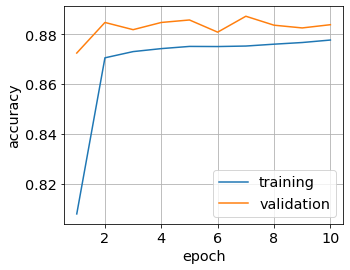

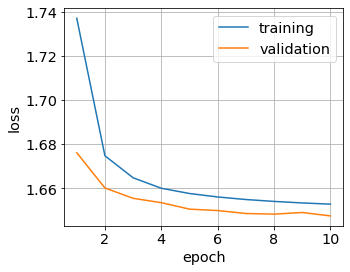

0.8777333498001099
0.883899986743927


C:\ProgramData\Anaconda3\envs\tf_env\lib\site-packages\numpy\lib\npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


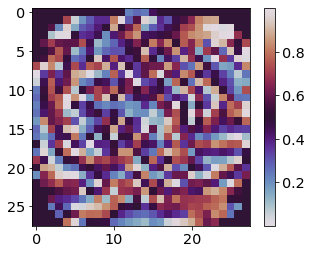

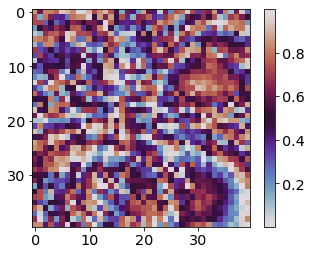

In [13]:
'''keys = history.history.keys()
print("Best Results:", zBest,pBest)'''
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (5,4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

pylab.rcParams.update(params)

#Plot Accuracy
plt.figure()
plt.plot(range(1,11),history.history[ 'sparse_categorical_accuracy'], label = "training")
plt.plot(range(1,11),history.history['val_sparse_categorical_accuracy'], label = "validation")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid()
plt.legend()
plt.show()

#Plot Loss
plt.figure()
plt.plot(range(1,11),history.history['loss'], label = "training")
plt.plot(range(1,11),history.history['val_loss'], label = "validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.show()

print(history.history[ 'sparse_categorical_accuracy'][-1])
print(history.history[ 'val_sparse_categorical_accuracy'][-1])

#Plot and save Phase of Model
#Get Weights
w = []
for i,weights in enumerate(model.get_weights()):
    w.append(weights)

#Plot Weights
res = []
y = w[0]
y[y<0] +=1
y[y>1] -=1
plt.figure()
plt.imshow(np.reshape(y, (28,28)), cmap = "twilight")
plt.colorbar()
res.append(np.reshape(y, (28,28)))

y = w[2]
y[y<0] +=1
y[y>1] -=1
plt.figure()
plt.imshow(np.reshape(y, (40,40)), cmap = "twilight")
plt.colorbar()
res.append(np.reshape(y, (40,40)))

#save
np.save("Optim_28x40_new", res)

<Figure size 360x288 with 0 Axes>

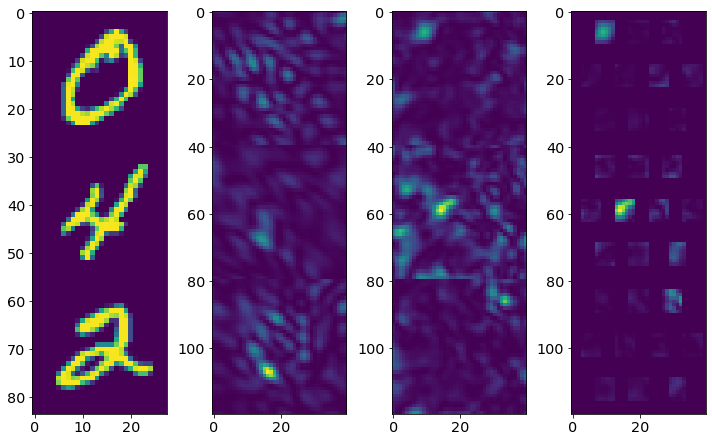

In [15]:
# Plot Propagation through system
N_mesh = 40

#Define the outputs I am interested in
model_part_1 = Model(
  inputs=model.input,
  outputs=model.get_layer(index = 4).output)
model_part_2 = Model(
  inputs=model.input,
  outputs=model.get_layer(index = 6).output)

#detector Mask
a, b = getDetector(N_mesh = N_mesh)
mask = np.reshape(a[0],(N_mesh,N_mesh))

#Get intermediate output of test images
testImages = np.array([x_train[1],x_train[9],x_train[5]])
out1 = [i /np.max(i) for i in model_part_1(testImages)]
out2 = [i /np.max(i) for i in model_part_2(testImages)]

ax0 = np.reshape(testImages, (3*28,28))
ax1 = np.abs(np.reshape(out1, (3*N_mesh,N_mesh)))**2
ax2 = np.abs(np.reshape(out2, (3,N_mesh,N_mesh)))**2
ax3 = np.array([np.reshape(mask, (N_mesh,N_mesh))*ax for ax in ax2])
ax3 = np.reshape(ax3, (3*N_mesh,N_mesh))
ax2 =  np.reshape(ax2, (3*N_mesh,N_mesh))


plt.figure()
fig, axs = plt.subplots(1,4, figsize = (10,10))
axs[0].imshow(ax0)
axs[1].imshow(ax1)
axs[2].imshow(ax2)
axs[3].imshow(ax3)
fig.tight_layout()
plt.show()
plt.close()


### Old Simulation Parameters
ABORTED BECAUSE TWO FIRST EPOCHS OF OTHER SIM ARE BETTER

In [38]:
#Train properly for best parameter
batch_size = 8
epochs     = 10

dScale1, dScale2, dScale3, z1, z2 = (0.82*28/lam, 0.705*40/lam, 1.102*40/lam, 30.52/lam, 37.4/lam)
# Train Model
model2      = get_model(input_shape, N_meta = N_meta, N_mesh = 40, 
                        D_scale1 = dScale1, D_scale2 = dScale2, D_scale3 = dScale3, 
                        zScale1 = z1, zScale2 = z2, lam = lam)
t = time.time()
history        = model2.fit(x_train, y_train,
    batch_size = batch_size,
    shuffle    = True,
    verbose    = 1,
    epochs     = epochs,
    callbacks  = tf.keras.callbacks.EarlyStopping(patience=2),
    validation_data = (x_test, y_test))
print("The training required:\t", time.time()-t, "s")


Epoch 1/10
7500/7500 [==============================] - 135s 16ms/step - loss: 1.7872 - sparse_categorical_accuracy: 0.7770 - val_loss: 1.7190 - val_sparse_categorical_accuracy: 0.8538
Epoch 2/10
7500/7500 [==============================] - 113s 15ms/step - loss: 1.7166 - sparse_categorical_accuracy: 0.8550 - val_loss: 1.7081 - val_sparse_categorical_accuracy: 0.8604
Epoch 3/10
7500/7500 [==============================] - 115s 15ms/step - loss: 1.7095 - sparse_categorical_accuracy: 0.8602 - val_loss: 1.7031 - val_sparse_categorical_accuracy: 0.8668
Epoch 4/10
7500/7500 [==============================] - 116s 15ms/step - loss: 1.7067 - sparse_categorical_accuracy: 0.8597 - val_loss: 1.7011 - val_sparse_categorical_accuracy: 0.8644
Epoch 5/10
 107/7500 [..............................] - ETA: 1:44 - loss: 1.7062 - sparse_categorical_accuracy: 0.8610

KeyboardInterrupt: 